In [1]:
# this just checks that i have the right kernel running
import sys
print(sys.executable)

import random
random.seed(0)

/Users/emmanechamkin/miniconda3/envs/advml/bin/python


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from config import *

# use keras tokenizer instead
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer 
import json

# building a NN model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import metrics

# building a sentiment NN
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense, Dropout

# import extra metrics
import keras_metrics 
#(https://stackoverflow.com/questions/
# 43076609/how-to-calculate-precision-and-recall-in-keras)
from sklearn import metrics as sklearn_metrics

Using TensorFlow backend.


# Heavily inspired by the following tutorials
- https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
- https://www.kaggle.com/lalitparihar44/detailed-text-based-feature-engineering
- https://machinelearnings.co/text-classification-using-neural-networks-f5cd7b8765c6
- https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
- https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
- https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/
- https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1

Many of the techniques I used in Keras, I "learned" via these online tutorials and then applied to my own work. Many of the thought processes are quite similar to those in these tutorials -- I picked and chose what would work for me, and then I adapted as necessary. 

## Why is there not test metrics?

There is such a huge difference between training and testing in terms of overfitting that testing doesn't make a ton of sense. We see massive overfitting to training data, which suggests that there needs to be more input data so that we can do things to decrease overfitting, rather than show another metric!

## explore training data

In [3]:
train_df = pd.read_csv(TRAIN)

In [4]:
### only training data now
tweet_corpus = train_df.iloc[:, 0]
tweet_sentiment = train_df.iloc[:, 1]

# note that I do this in both files. I wanted to keep 
# my categories flexible from file to file, and this is 
# the execution of a single switch. I didn't think I 
# absolutely needed to refactor here. 
tweet_sentiment_coded = pd.Series(np.where(
    tweet_sentiment == 'About the police - Positive', 1, 
        np.where(tweet_sentiment == 'About the police - Negative', 2, 
            np.where(tweet_sentiment == 'About the police - Neutral', 3, 
                np.where(tweet_sentiment == 'Not about the police', 0, "Error")))))

In [5]:
tweet_sentiment.value_counts()

About the police - Neutral     257
Not about the police           242
About the police - Positive    135
About the police - Negative    134
Name: Answer.sentiment.label, dtype: int64

In [6]:
test_df = pd.read_csv(VALIDATE)
test_corpus = test_df.iloc[:, 0]
test_sentiment = test_df.iloc[:, 1]

test_all_4 = pd.Series(np.where(
    test_sentiment == 'About the police - Positive', 1, 
        np.where(test_sentiment == 'About the police - Negative', 2, 
            np.where(test_sentiment == 'About the police - Neutral', 3, 
                np.where(test_sentiment == 'Not about the police', 0, "Error")))))

test_opinion = pd.Series(np.where(
    test_sentiment == 'About the police - Positive', 1, 
        np.where(test_sentiment == 'About the police - Negative', 1, 0)))

test_negative = pd.Series(np.where(
    test_sentiment == 'About the police - Negative', 1, 0))

test_sentiment.value_counts()

About the police - Neutral     284
Not about the police           197
About the police - Negative    152
About the police - Positive    135
Name: Answer.sentiment.label, dtype: int64

## create a dictionary file

This was inspired by: https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/

In [7]:
# only work with the most popular words found in our dataset
MAX_WORDS = 2000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(tweet_corpus)

dictionary = tokenizer.word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

## additional utility code

In [37]:
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

def plot_keras_metrics(train_history, flag=True):
    """
    Utility code for plots
    Input train_history, a keras object
    Returns nothing, generates plot
    """
    if flag:
        plt.plot(train_history.history['val_precision'])
        plt.plot(train_history.history['precision'])
        plt.title('model precision')
        plt.ylabel('precision')
        plt.xlabel('epoch')
        plt.legend(['validation', 'train'], loc='upper left')
        plt.show()

    plt.plot(train_history.history['val_categorical_accuracy'])
    plt.plot(train_history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['validation', 'train'], loc='upper left')
    plt.show()
    
    plt.plot(train_history.history['val_loss'])
    plt.plot(train_history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['validation', 'train'], loc='upper left')
    plt.show()

## build a basic neural net using Keras

In [9]:
def convert_text_to_index_array(text):
    """
    Makes all text the same length
    """
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]


def generate_x_y(tweet_x, tweet_y, dictionary=dictionary):
    """
    Generate x, y given a dictionary of words
    """
    indices = []

    # for each tweet, change each token to its ID in the Tokenizer's word_index
    for text in tweet_x:
        word_indices = [dictionary[word] 
                        for word in kpt.text_to_word_sequence(text)
                        if word in dictionary]
        indices.append(word_indices)

    # cast as an array for future usage.
    indices = np.asarray(indices)

    # create one-hot matrices out of the indexed tweets
    x = tokenizer.sequences_to_matrix(indices, mode='binary')
    # treat the labels as categories
    y = keras.utils.to_categorical(tweet_y)
    
    return x, y

In [10]:
train_x, train_y = generate_x_y(tweet_corpus, tweet_sentiment_coded, dictionary=dictionary)
test_x, test_y = generate_x_y(test_corpus, test_all_4, dictionary=dictionary)

In [11]:
train_x.shape

(768, 2000)

In [12]:
test_x.shape

(768, 2000)

## Preliminary Neural Net 

In [13]:
# here, I construct the model layers for this project. 
# regardless of the number of layer, dropout rate, activation
# function, this neural net performs terribly, but you 
# can see the summary for this example below. I also tried with 
# three layers only. 
model = Sequential()
model.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(150, activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)  

## train the model

The statistic on the validation set here suggests just how terrible this model truly was. I did not pursue this further. 

In [14]:
model_history = model.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 2s 3ms/step - loss: 1.3838 - mean_absolute_error: 0.3747 - categorical_accuracy: 0.3017 - val_loss: 1.3801 - val_mean_absolute_error: 0.3742 - val_categorical_accuracy: 0.3290
Epoch 2/25
537/537 [==============================] - 0s 257us/step - loss: 1.3799 - mean_absolute_error: 0.3742 - categorical_accuracy: 0.3259 - val_loss: 1.3754 - val_mean_absolute_error: 0.3736 - val_categorical_accuracy: 0.3290
Epoch 3/25
537/537 [==============================] - 0s 259us/step - loss: 1.3771 - mean_absolute_error: 0.3738 - categorical_accuracy: 0.2812 - val_loss: 1.3710 - val_mean_absolute_error: 0.3730 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 0s 257us/step - loss: 1.3741 - mean_absolute_error: 0.3733 - categorical_accuracy: 0.3277 - val_loss: 1.3678 - val_mean_absolute_error: 0.3725 - val_categoric

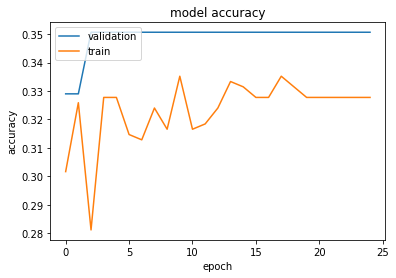

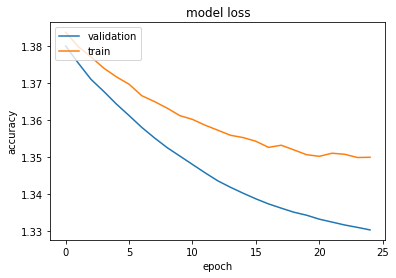

In [15]:
plot_keras_metrics(model_history, flag=False)

## showing other options

Here I construct two additional models -- one with no drop out and one with fewer layers -- to demonstrate that the dearth of data is ruining the model. It is not behaving as we would expect it to. 

In [16]:
no_drop_out = Sequential()
no_drop_out.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
no_drop_out.add(Dense(100, activation='relu'))
no_drop_out.add(Dense(100, activation='sigmoid'))
no_drop_out.add(Dense(4, activation='softmax'))

no_drop_out.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(no_drop_out.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               200100    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 404       
Total params: 220,704
Trainable params: 220,704
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
ndo_model = no_drop_out.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 1s 2ms/step - loss: 1.5144 - mean_absolute_error: 0.3688 - categorical_accuracy: 0.3091 - val_loss: 1.3807 - val_mean_absolute_error: 0.3659 - val_categorical_accuracy: 0.3290
Epoch 2/25
537/537 [==============================] - 0s 147us/step - loss: 1.3696 - mean_absolute_error: 0.3678 - categorical_accuracy: 0.2868 - val_loss: 1.3287 - val_mean_absolute_error: 0.3640 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 0s 146us/step - loss: 1.3526 - mean_absolute_error: 0.3662 - categorical_accuracy: 0.3277 - val_loss: 1.3352 - val_mean_absolute_error: 0.3631 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 0s 153us/step - loss: 1.3543 - mean_absolute_error: 0.3656 - categorical_accuracy: 0.3277 - val_loss: 1.3257 - val_mean_absolute_error: 0.3621 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [========

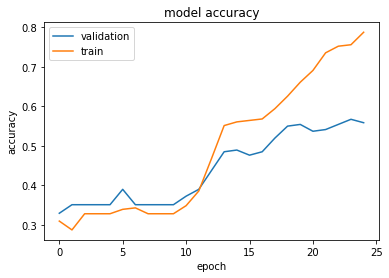

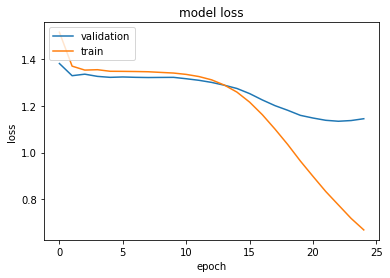

In [38]:
plot_keras_metrics(ndo_model, flag=False)

Fewer layers is definitely *better* by a little -- it has about 50% accuracy -- but still less than ideal and very overfit. 

In [19]:
few_layers = Sequential()
few_layers.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
few_layers.add(Dropout(0.25))

few_layers.add(Dense(100, activation='relu'))
few_layers.add(Dropout(0.25))

few_layers.add(Dense(4, activation='softmax'))

few_layers.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(few_layers.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               200100    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 404       
Total params: 210,604
Trainable params: 210,604
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
few_layers_history = few_layers.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3814 - mean_absolute_error: 0.3743 - categorical_accuracy: 0.2942 - val_loss: 1.3692 - val_mean_absolute_error: 0.3727 - val_categorical_accuracy: 0.3506
Epoch 2/25
537/537 [==============================] - 0s 169us/step - loss: 1.3693 - mean_absolute_error: 0.3726 - categorical_accuracy: 0.3333 - val_loss: 1.3569 - val_mean_absolute_error: 0.3708 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 0s 171us/step - loss: 1.3609 - mean_absolute_error: 0.3711 - categorical_accuracy: 0.3408 - val_loss: 1.3451 - val_mean_absolute_error: 0.3687 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 0s 174us/step - loss: 1.3522 - mean_absolute_error: 0.3692 - categorical_accuracy: 0.3352 - val_loss: 1.3362 - val_mean_absolute_error: 0.3668 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [========

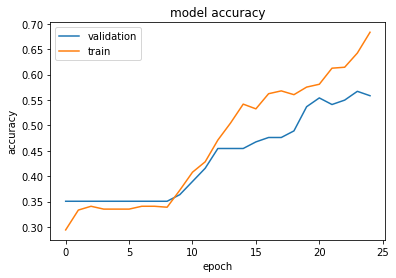

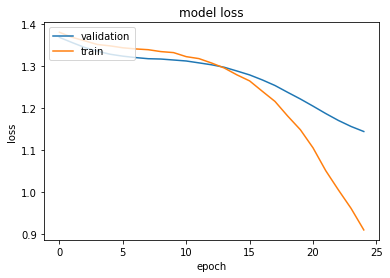

In [39]:
plot_keras_metrics(few_layers_history, False)

As one last hail mary, I wanted to see if I simply detected negative sentiment, if this model would work... 

This ends up being somewhat good, but not better than traditional models or baseline, and a lot more opaque. The precision is way better, though. 

In [22]:
simple_few_layers = Sequential()
simple_few_layers.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
simple_few_layers.add(Dropout(0.25))
simple_few_layers.add(Dense(100, activation='relu'))
simple_few_layers.add(Dropout(0.25))
simple_few_layers.add(Dense(2, activation='softmax'))
simple_few_layers.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, keras_metrics.precision(), metrics.categorical_accuracy])
print(simple_few_layers.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               200100    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 210,402
Trainable params: 210,402
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
simple_tweet_sentiment_coded = pd.Series(
    np.where(tweet_sentiment == 'About the police - Negative', 1, 0))
simple_train_y = keras.utils.to_categorical(simple_tweet_sentiment_coded)
simple_test_y = keras.utils.to_categorical(test_negative)

In [24]:
train_history = simple_few_layers.fit(train_x, simple_train_y,
  batch_size=64,
  epochs=30,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/30
537/537 [==============================] - 1s 2ms/step - loss: 0.6766 - mean_absolute_error: 0.4914 - precision: 0.8356 - categorical_accuracy: 0.7356 - val_loss: 0.6445 - val_mean_absolute_error: 0.4743 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 2/30
537/537 [==============================] - 0s 174us/step - loss: 0.6280 - mean_absolute_error: 0.4643 - precision: 0.8194 - categorical_accuracy: 0.8194 - val_loss: 0.5962 - val_mean_absolute_error: 0.4455 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 3/30
537/537 [==============================] - 0s 501us/step - loss: 0.5848 - mean_absolute_error: 0.4365 - precision: 0.8194 - categorical_accuracy: 0.8194 - val_loss: 0.5489 - val_mean_absolute_error: 0.4129 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 4/30
537/537 [==============================] - 0s 163us/step - loss: 0.5399 - mean_absolute_error: 0.4031 - precision: 0.

# plotting some results

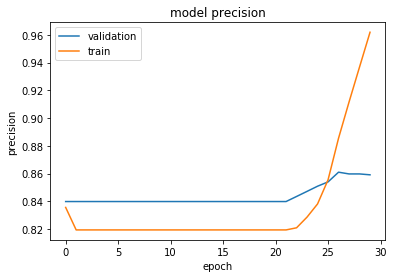

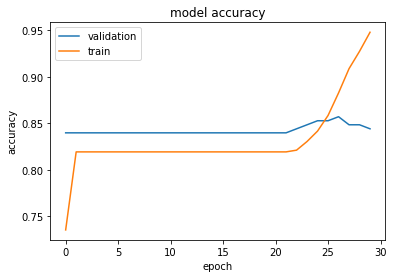

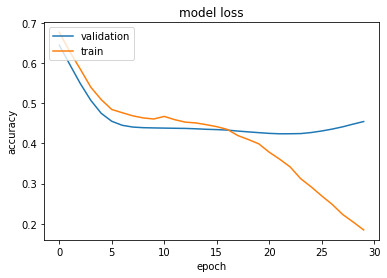

In [25]:
plot_keras_metrics(train_history)

## can I detect public sentiment vs. neutral?

In [26]:
opinion_detector = pd.Series(
    np.where(tweet_sentiment == 'About the police - Negative', 1, 
            np.where(tweet_sentiment == 'About the police - Positive', 1, 0)))
opinion_detector_y = keras.utils.to_categorical(opinion_detector)

In [27]:
opinion_train_history = simple_few_layers.fit(train_x, opinion_detector_y,
  batch_size=64,
  epochs=20,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/20
537/537 [==============================] - 0s 174us/step - loss: 0.6574 - mean_absolute_error: 0.2794 - precision: 0.7517 - categorical_accuracy: 0.7784 - val_loss: 0.6427 - val_mean_absolute_error: 0.3728 - val_precision: 0.6980 - val_categorical_accuracy: 0.6667
Epoch 2/20
537/537 [==============================] - 0s 171us/step - loss: 0.5151 - mean_absolute_error: 0.2942 - precision: 0.7729 - categorical_accuracy: 0.7840 - val_loss: 0.6582 - val_mean_absolute_error: 0.4283 - val_precision: 0.7630 - val_categorical_accuracy: 0.6277
Epoch 3/20
537/537 [==============================] - 0s 167us/step - loss: 0.4736 - mean_absolute_error: 0.3191 - precision: 0.7979 - categorical_accuracy: 0.7803 - val_loss: 0.7049 - val_mean_absolute_error: 0.4515 - val_precision: 0.7944 - val_categorical_accuracy: 0.5931
Epoch 4/20
537/537 [==============================] - 0s 173us/step - loss: 0.4516 - mean_absolute_error: 0.3136 - precision: 

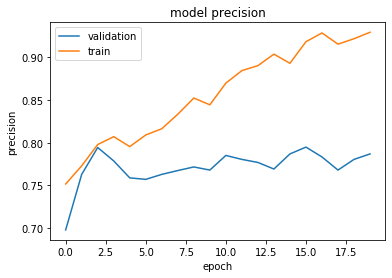

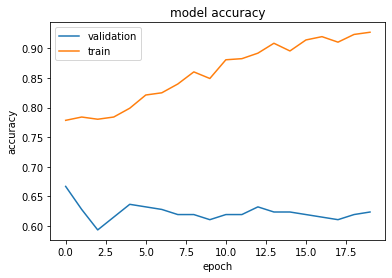

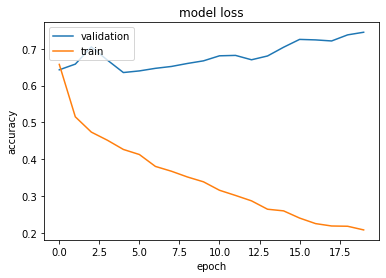

In [28]:
plot_keras_metrics(opinion_train_history)

# building a sentiment RNN

Tutorial source:
https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

In [29]:
MAX_LEN_TWEET = 30
EMBEDDING_SIZE = 5
BATCH_SIZE = 64
EPOCHS_NUMBER = 25

In [30]:
# padding sequences to get uniform length, similar to above
train_x_rnn = sequence.pad_sequences(train_x, maxlen=MAX_LEN_TWEET)

## construct the model
As before, this is just one example of the many examples that failed :) I tried more types -- more layers, less layers, different activations -- but this seemed like a good representative model to demonstrate that this... didn't really work

In [31]:
rnn = Sequential()
rnn.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
rnn.add(Dropout(0.25))
rnn.add(LSTM(100))
rnn.add(Dropout(0.25))
rnn.add(Dense(4, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, metrics.categorical_accuracy])

print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 5)             150       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 404       
Total params: 42,954
Trainable params: 42,954
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
rnn.fit(
    train_x_rnn, train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 3s 6ms/step - loss: 1.3820 - mean_absolute_error: 0.4985 - categorical_accuracy: 0.2942 - val_loss: 1.3699 - val_mean_absolute_error: 0.4943 - val_categorical_accuracy: 0.3506
Epoch 2/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3651 - mean_absolute_error: 0.4863 - categorical_accuracy: 0.3128 - val_loss: 1.3212 - val_mean_absolute_error: 0.4621 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3526 - mean_absolute_error: 0.4749 - categorical_accuracy: 0.3259 - val_loss: 1.3360 - val_mean_absolute_error: 0.4793 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3533 - mean_absolute_error: 0.4836 - categorical_accuracy: 0.3277 - val_loss: 1.3287 - val_mean_absolute_error: 0.4749 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [==============

## additional models

As above, I wanted to show a few samples of other things that didn't work :)

In [33]:
no_dropout = Sequential()
no_dropout.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
no_dropout.add(LSTM(100))
no_dropout.add(Dense(4, activation='sigmoid'))
no_dropout.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, metrics.categorical_accuracy])

no_dropout.fit(
    train_x_rnn, train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 3s 6ms/step - loss: 1.3808 - mean_absolute_error: 0.4983 - categorical_accuracy: 0.3277 - val_loss: 1.3670 - val_mean_absolute_error: 0.4931 - val_categorical_accuracy: 0.3506
Epoch 2/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3680 - mean_absolute_error: 0.4844 - categorical_accuracy: 0.3277 - val_loss: 1.3228 - val_mean_absolute_error: 0.4652 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3510 - mean_absolute_error: 0.4802 - categorical_accuracy: 0.3277 - val_loss: 1.3413 - val_mean_absolute_error: 0.4818 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3538 - mean_absolute_error: 0.4841 - categorical_accuracy: 0.3277 - val_loss: 1.3316 - val_mean_absolute_error: 0.4759 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [==============

## rnn negative sentiment only

In [34]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
simple_rnn.add(Dropout(0.25))
simple_rnn.add(LSTM(100))
simple_rnn.add(Dropout(0.25))
simple_rnn.add(Dense(2, activation='sigmoid'))
simple_rnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, keras_metrics.precision(), metrics.categorical_accuracy])

print(simple_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 5)             150       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 5)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 202       
Total params: 42,752
Trainable params: 42,752
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
train_history_rnn = simple_rnn.fit(
    train_x_rnn, simple_train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER, 
    shuffle=True,
    verbose=1)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 3s 6ms/step - loss: 0.6738 - mean_absolute_error: 0.4899 - precision: 0.8244 - categorical_accuracy: 0.8156 - val_loss: 0.6298 - val_mean_absolute_error: 0.4655 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 2/25
537/537 [==============================] - 1s 2ms/step - loss: 0.5617 - mean_absolute_error: 0.3843 - precision: 0.8194 - categorical_accuracy: 0.8194 - val_loss: 0.4432 - val_mean_absolute_error: 0.2393 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 3/25
537/537 [==============================] - 1s 1ms/step - loss: 0.4845 - mean_absolute_error: 0.2951 - precision: 0.8194 - categorical_accuracy: 0.8194 - val_loss: 0.4487 - val_mean_absolute_error: 0.2888 - val_precision: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 4/25
537/537 [==============================] - 1s 1ms/step - loss: 0.4765 - mean_absolute_error: 0.2758 - precision: 0.8194 -

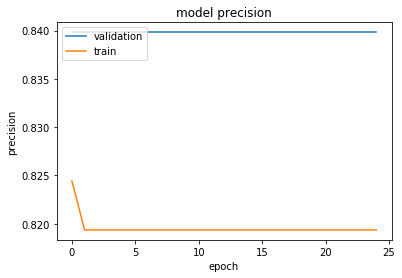

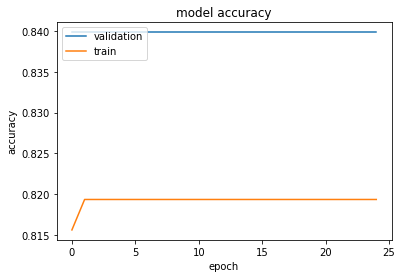

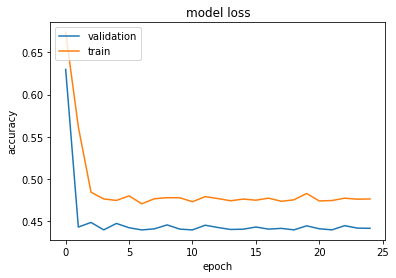

In [36]:
plot_keras_metrics(train_history_rnn)